# ERP Preprocessing and Derivation Using MNE

This notebook reads in a raw EGI/Netstation simple binary format continuous EEG data file with trigger codes, and preprocesses it (including filtering, segmentation, artifact detection/ICA correction), and plots means for each experimental condition.

This relies on the MNE-python package, and several python libraries. At the least, to run this you'll need to do the following:
- download and install miniconda from continuum.org
- once miniconda is installed, open a Terminal (OS X) or Anaconda prompt (Windows), and enter the following commands:
    - `conda install numpy scipy pandas matplotlib scikit-learn jupyter`
    - `pip install mne`
- once those commands have run, you would type `jupyter notebook` and then load this notebook's `.ipynb` file


---
Copyright (c) 2016 Aaron J Newman, NeuroCognitive Imaging Lab, Dalhousie University

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301, USA.

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib

import mne
import glob, os
from mne.io.reference import set_eeg_reference
mne.set_log_level('error')

## Set Subject Number

In [2]:
subject = '11'

## Event Code Stuff

In [3]:
#the order of these events of interest are based on the order in which the pins are set in the PsychoPy script
events_of_interest = {'nega':1, 'posi':2, 'neut':3, 'warn':4,'onli':5}

#make an array of the conditions of interest, in alphabetical order
cond_of_interest = ['nega','neut','onli','posi','warn']

#cond_of_interest = events_of_interest.keys()


# The following should be the differences you want to compute, in terms of the indices in cond_of_interest.
# For each pair of conds, differences will be computed as 0-1 (first index - second index)

expt_contrasts = ("nega_diff", "posi_diff", "warn_diff", "onli_diff", "warn_comp")

expt_contrast_conds = [[0, 1], [3, 1], [4, 1], [2, 1], [4, 2]]

## Other Parameters

In [4]:
# VEOG: we use E14, E21, E126, and E127
# HEOG: we use E125 and E128
# Note python indices are 1 less than EGI channel numbers

eog_inds = ["HEOG", "VEOG"]

# PARAMETERS FOR EPOCHING 
# Bradley et al. (2007) did -100 to 700. 
# Hajcak and Olvet (2008) did -200 to 3000ms (with 2000ms picture display)
# We now display the pic for 2 sec so let's try that (Jan 10)

tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 2  # end of each epoch (2000ms after the trigger)
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(eeg=200e-6, eog=200e-6)  # EEG data are in V, so e-6 gives microVolts

montage_fname = 'standard_1020'
# montage_path = '.' # tried to add a path, it did not work :(
# montage = mne.channels.read_montage(montage_fname) # got an error saying that 'read_montage' has depreciated. It suggested a bunch of alternatives which I will try now - seems to run with 'make_standard_montage' instead.

# channels you want to re-reference to for the final results
ref_channels=['TP9','TP10']

l_freq = 0.1
h_freq = 40.0
l_trans_bandwidth = 'auto'
h_trans_bandwidth = 'auto'
filter_length='auto'

# maximum number of ICs to reject in ICA artifact correction
ica_random_state = 42  # seed so ICA is reproducable each time it's run
eog_threshold = 1.96 # z transformation of correlation between ICs and EOG channel
n_max_ecg = 3
n_max_eog = 3
n_components = .975

eeg_scaling = dict(eeg=100)  # 100 for EGI; 200e-6 for ANT

data_path = '../Data/' + subject + "/"
out_path = '../Data/' + subject + '/'

if not os.path.exists(out_path):
    os.makedirs(out_path)
    
# output file names
events_fname     = out_path + subject + '-eve.fif'
epochs_fname     = out_path + subject + '-epo.fif'
evoked_fname     = out_path + subject + '-ave.fif'
covariance_fname = out_path + subject + '-cov.fif'
trans_name       = out_path + subject + '-trans.fif'
forward_fname    = out_path + subject + '-fwd.fif'
inverse_fname    = out_path + subject + '-inv.fif'

## Import Data

In [5]:
raw_fname = data_path + "11.set"

raw = mne.io.read_raw_eeglab(raw_fname, eog=eog_inds, preload = True) 
raw.set_montage(montage_fname)

events, event_dict = mne.events_from_annotations(raw)

mne.write_events(events_fname, events)

In [6]:
#changed from inline to qt5 to get the pop-out

%matplotlib qt5
raw.plot(n_channels=34, start=50, duration=5);

## Filtering

First plot frequency spectrum prior to filtering, for later comparison.

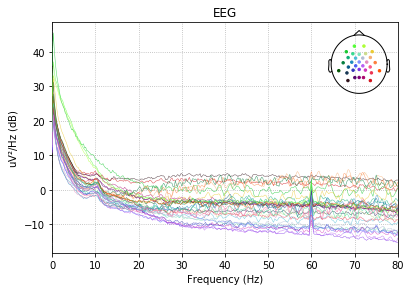

In [7]:
%matplotlib inline

raw.plot_psd(fmax=80, tmax=np.inf, n_jobs=6, spatial_colors=True, average=False);

### Now bandpass filter, then plot filtered data

/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


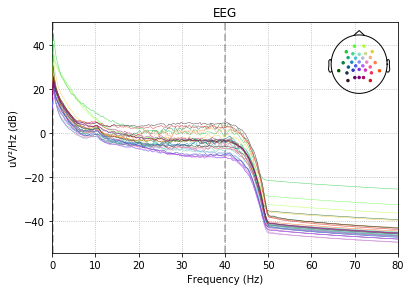

In [8]:
raw.filter(l_freq, h_freq, l_trans_bandwidth = l_trans_bandwidth, h_trans_bandwidth = h_trans_bandwidth, 
           filter_length=filter_length, method='fft', n_jobs = 6)  
raw.plot_psd(fmax=80, tmax=np.inf, n_jobs=6, spatial_colors=True, average=False);

## Interactive plot of continuous data - identify and mark bad channels
Scroll through the plot to identify channels for exclusion from analysis. 

Note that `%matplotlib notebook` is required for interactivity with the plot, but it's a bit flaky. You may have to execute this cell a few times before it finally draws the plot for you.

In [9]:
#from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas

%matplotlib qt5
#%matplotlib inline

raw.plot(n_channels=32, scalings=dict(eeg=.0001,eog=.0001,bio=.01), duration=25, event_color='blue');

### Drop channels
If channels look bad, drop them here.

In [42]:
#raw.drop_channels(['P7']) # seems ok

Label any channel you want placed into 'bads' below

## Event Processing

Event codes are collated in a 'channel' called STI 014

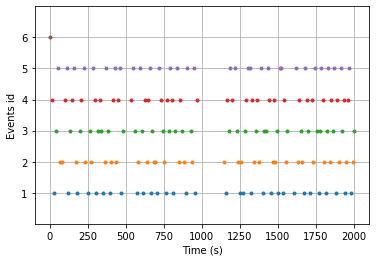

In [10]:
%matplotlib inline
fig = mne.viz.plot_events(events, raw.info['sfreq']);

## Epoching

In [16]:
event_id = {}
for event_key in events_of_interest:
    if event_key in event_id:
        event_id[events_of_interest[event_key]] = raw.event_id[event_key]

In [35]:
picks_eeg = mne.pick_types(raw.info, eeg=True, eog=True,
                           stim=False, exclude=[])  # we need to keep the bads in the list

epochs = mne.Epochs(raw, events, events_of_interest, tmin, tmax, proj=False,
                   picks=picks_eeg, baseline=baseline, on_missing='ignore', preload=False 
                    )

In [36]:
print(epochs) # gives us number of trials per condition prior to artrej

<Epochs  |   160 events (good & bad), -0.199219 - 2 sec, baseline [None, 0], ~97 kB, data not loaded,
 'nega': 32
 'neut': 32
 'onli': 32
 'posi': 32
 'warn': 32>


## Plot epochs and go through, manually marking bad trials
Click on a trial to mark it bad. When you close the window, the marked trials will be saved to the "drops" in the epochs data structure.

Note that `%matplotlib notebook` is required for interactivity with the plot, but it's a bit flaky. You may have to execute this cell a few times before it finally draws the plot for you.

In [37]:
%matplotlib qt5  
epochs.plot(scalings=dict(eeg=0.0002), n_channels=129, picks=picks_eeg);

### Reproducable science
The problem with manual rejection through the GUI is that we don't have a record here in the script of which trials were rejected. So if we have to redo this step, it might be done differently, which will affect all subsequent steps (notably ICA).

Therefore, we identify the bad trials visually, but exclude them manually by listing them in the cell below.

Note that an alternative way to reject trials is to click on them in the interactive plot above. They will turn red and are then removed from the data structure for all subsequent steps. 
*BE CAREFUL* though, becuase *MNE renumbers the trials after rejection*. So, if you click on trials in the interactive plot, then list those trial numbers below and run `epochs.drop`, you will remove *double* the number of trials you intended - the latter half being actually-good trials.
Also, the "click" method is not a reproducible science approach, because if you re-run this notebook, you will have to re-identify and -mark the bad trials. So **do not use the click-to-reject approach**.

In [38]:
rej_trials = [4,15,16,73,89,101,102,105,121,146,158]

# indices in epochs.plot() start from 1, not 0, so we need to -1 from each index we manually identified
for k in range(len(rej_trials)):
    rej_trials[k] = rej_trials[k]
    
epochs.drop(rej_trials)

<Epochs  |   149 events (all good), -0.199219 - 2 sec, baseline [None, 0], ~97 kB, data not loaded,
 'nega': 30
 'neut': 31
 'onli': 28
 'posi': 29
 'warn': 31>

### Plot average of all epochs

Should look messy since we haven't done artifact rejection/correction yet

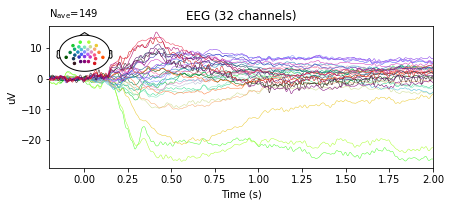

In [39]:
%matplotlib inline
epochs.average().plot(spatial_colors=True);

## Run ICA to identify and correct ocular artifacts

In [40]:
ica = mne.preprocessing.ICA(n_components=n_components, method='fastica', 
                            max_iter=500, random_state=ica_random_state)

#Note: had to make the eog False to make it work.
picks = mne.pick_types(epochs.info, meg=False, 
                       eeg=True, eog=False, stim=False, exclude='bads')

ica.fit(epochs, picks=picks, decim=3, reject=None)

<ICA  |  epochs decomposition, fit (fastica): 56024 samples, 12 components, channels used: "eeg">

### Plot scalp maps of each IC
Ocular artifact components should load heavily over the front of the head and little/not at all elsewhere.

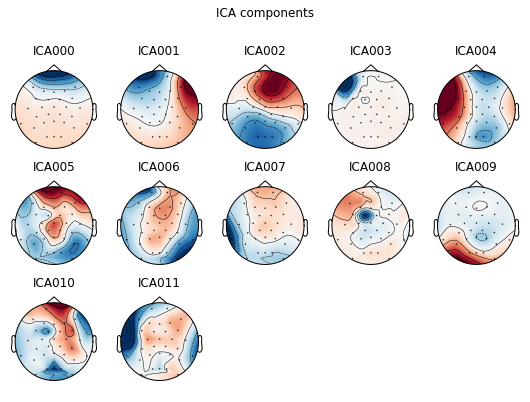

In [41]:
ica.plot_components(picks=None, ch_type='eeg');

### Plot individual components and do manual artifact selection
My practice is to leave only the plots of the components I marked for removal.

My criteria for rejection are:
1. Obvious ocular artifact (blinks weigh heavily on anterior channels, all same polarity; horizontal movements weight heavily on either side of the eyes, with opposite polarity on each side)
- Raster plots show that component weights heavily on a very low number of trials, and little/not at all on most trials
- "Epochs variance" is high on a low number of trials, and generally low on most trials
- Topo plot shows a very focal effect around a single electrode, with very little/no weighting at most other electrodes (keeping in mind that the topo plots are interpolated so there will be some "smearing" of an effect even at a single electrode) 
- No apparent correlation between average waveform (shown in bottom of raster plot) and an IC with a clear, strong, sensory ERP (i.e., no suggestion of part or all of a P1-N1-P2 complex)

Need to manually change the "picks" number for each plot based on visual inspection of the topo plots of the components, above.

In [ ]:
ica.plot_properties(epochs, picks=range(0,ica.n_components_));

### Manually specify ICs to remove, based on visual inspection
The automatic process doesn't remove as many ICs as necessary for EEG

In [28]:
ica.exclude = [0,1,2]

## Apply ICA corrections to data

In [29]:
#Got an error message that asked me to add this... so I added it. (?)
epochs.load_data()

epochs_postica = ica.apply(epochs.copy()).apply_baseline(baseline)

## Check epochs again post-ICA
Remove additional trials if they still look noisy, or go back and remove more ICs

In [30]:
%matplotlib qt5  
#%matplotlib inline
epochs_postica.plot(scalings=dict(eeg=0.0002), n_channels=128, picks=picks_eeg);

In [56]:
rej_trials = []
# indices in epochs.plot() start from 1, not 0, so we need to -1 from each index we manually identified
for k in range(len(rej_trials)):
    rej_trials[k] = rej_trials[k]-1
    
epochs_postica.drop(rej_trials)

Number of events,160
Events,nega: 32neut: 32onli: 32posi: 32warn: 32
Time range,-0.199 – 2.000 sec
Baseline,-0.199 – 0.000 sec


## Interpolate electrodes that were manually removed

In [57]:
epochs_postica.interpolate_bads()

Number of events,160
Events,nega: 32neut: 32onli: 32posi: 32warn: 32
Time range,-0.199 – 2.000 sec
Baseline,-0.199 – 0.000 sec


## Re-reference to average mastoids

In [59]:
epochs_postica_mstd = set_eeg_reference(epochs_postica, ref_channels=ref_channels)[0]
epochs_postica_mstd.save(epochs_fname)

%matplotlib inline
epochs_postica_mstd.average().plot(spatial_colors=True);

FileExistsError: Destination file exists. Please use option "overwrite=True" to force overwriting.

## Create Evoked Responses - Averaged epochs for each condition
Use dict comprehension to create a dict with separate entries for each condition.

In [60]:
#evokeds = [epochs_postica_mstd[cond].average() for cond in sorted(cond_of_interest)]
evokeds = [epochs_postica_mstd[cond].average() for cond in sorted(cond_of_interest)]
mne.write_evokeds(evoked_fname, evokeds)

In [61]:
#recode the events so they match evokeds' alphabetical order:
events_of_interest_evokeds = {'nega': 0, 'neut': 1, 'onli': 2, 'posi': 3, 'warn': 4}

### Butterfly plots for average of each condition

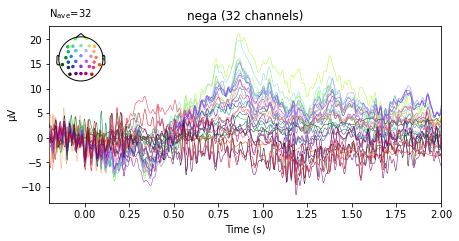

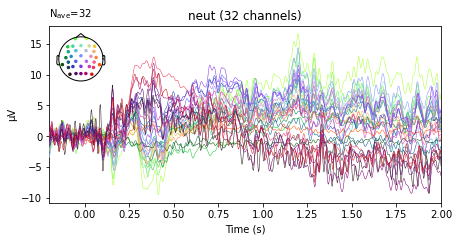

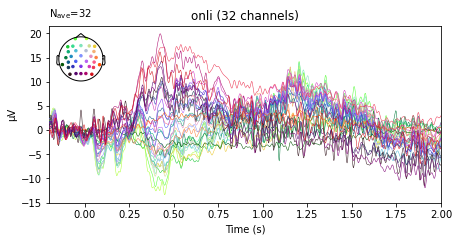

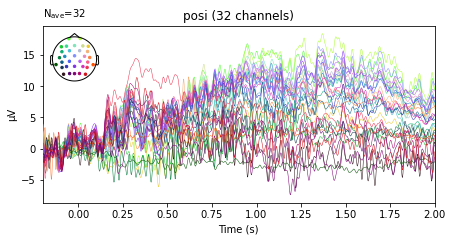

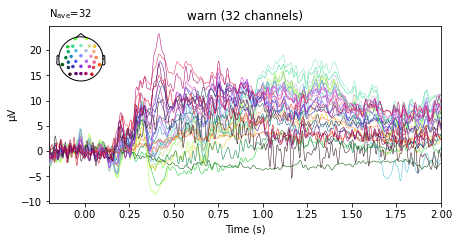

In [62]:
for cond in events_of_interest_evokeds:
    evokeds[events_of_interest_evokeds[cond]].plot(spatial_colors=True, titles=cond);

### Topoplots per condition

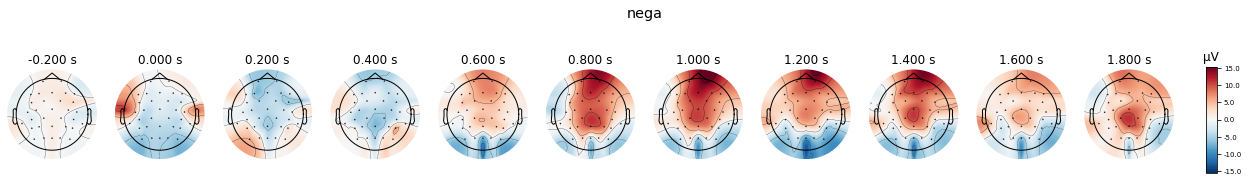

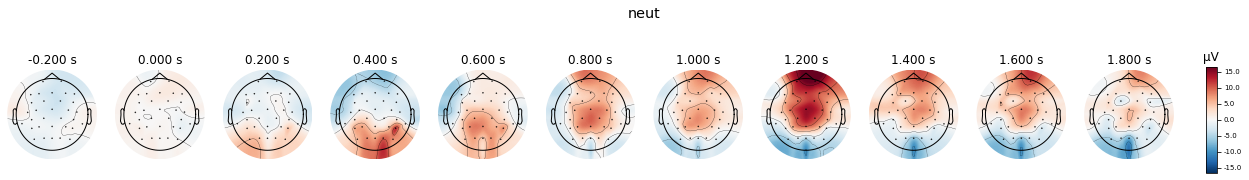

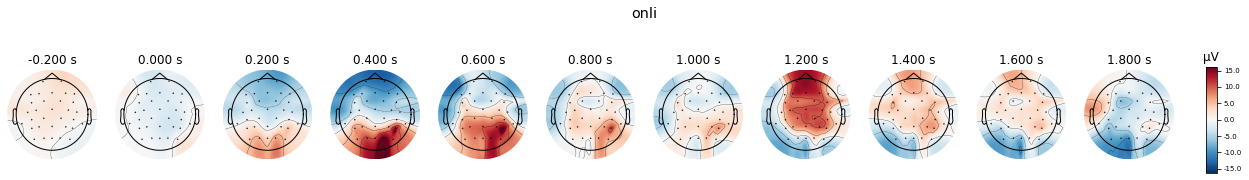

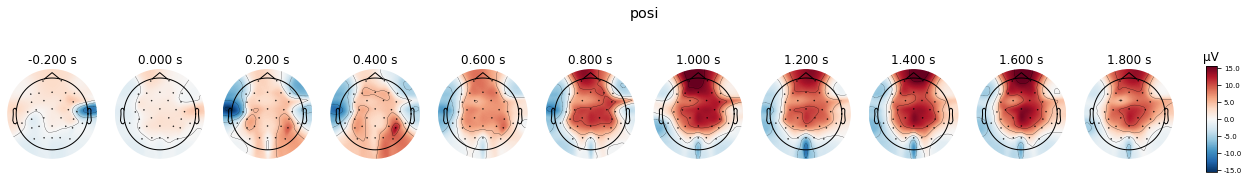

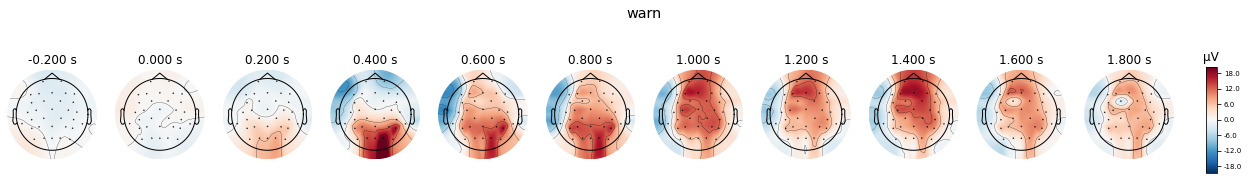

In [63]:
times = np.arange(-0.2, 2, 0.2)

for cond in cond_of_interest:
    [evokeds[cond_of_interest.index(cond)].plot_topomap(outlines='skirt', times=times, title=cond)];

## Differences

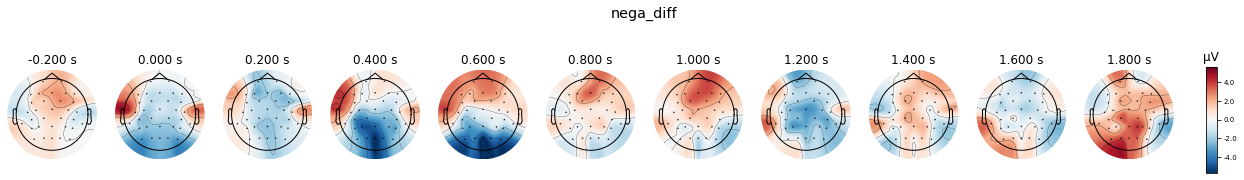

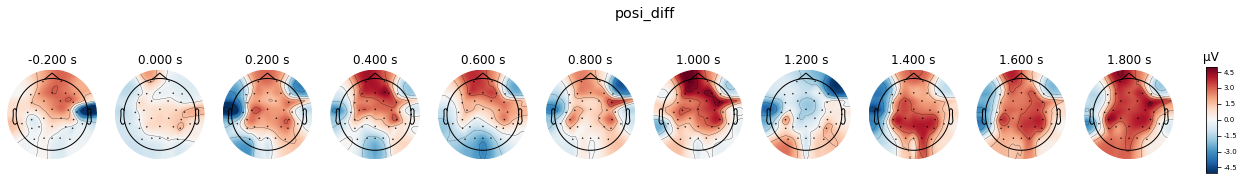

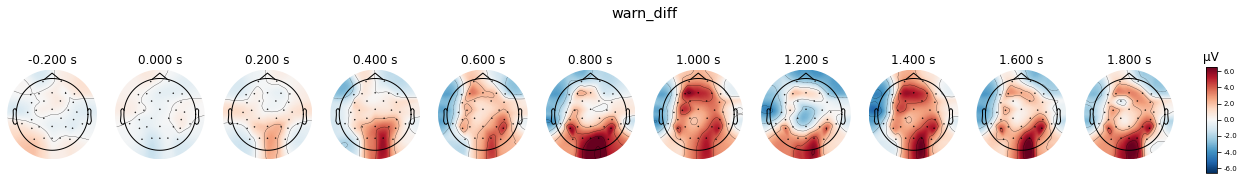

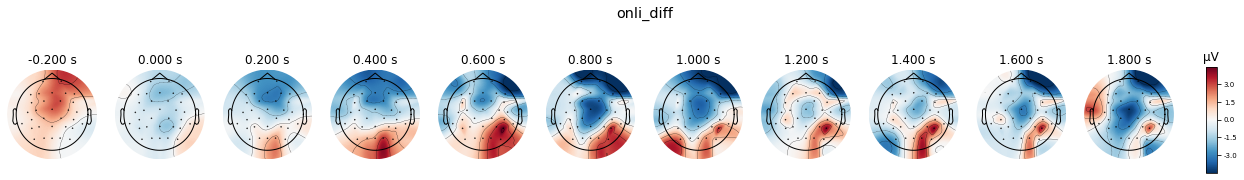

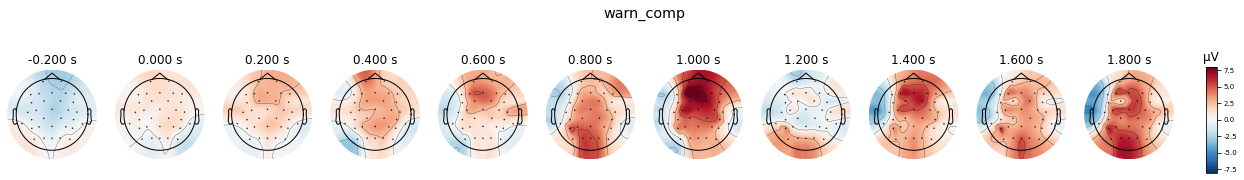

In [64]:
diffs = [mne.combine_evoked([evokeds[expt_contrast_conds[contr][0]], -evokeds[expt_contrast_conds[contr][1]]], 
                                     weights="equal") 
         for contr in range(0, len(expt_contrasts))]

times = np.arange(-0.2, 2, 0.2)

for contr in expt_contrasts:
    [diffs[expt_contrasts.index(contr)].plot_topomap(outlines='skirt', times=times, title=contr)];

## Draw the ERPs, average for each condition

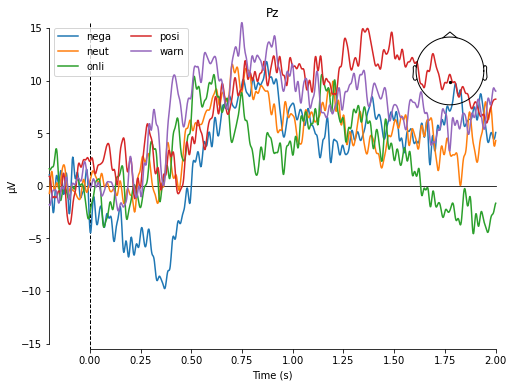

In [65]:
picks = evokeds[0].ch_names.index('Pz')

mne.viz.plot_compare_evokeds(evokeds, picks=picks);

#1 = nega, 2 = neut, 3 = onli, 4 = posi, and 5 = warn